In [1]:
from keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import random
from config import *
from util import *

# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

C:\PycharmProjects\Apnea\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Dataset

Using **CIFAR10** for our implementation.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

Index selected: 197.


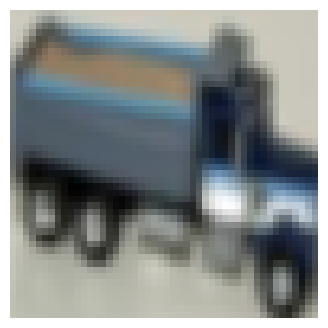

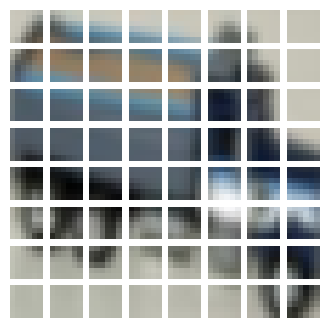

In [4]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmeneted_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmeneted_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmeneted_images, patches=patches)

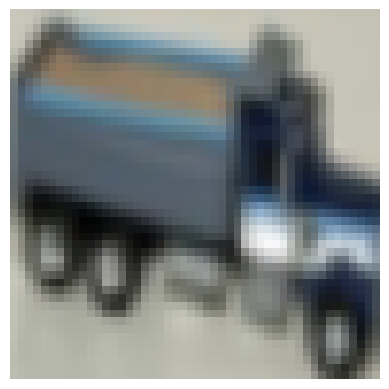

In [5]:
# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [6]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)

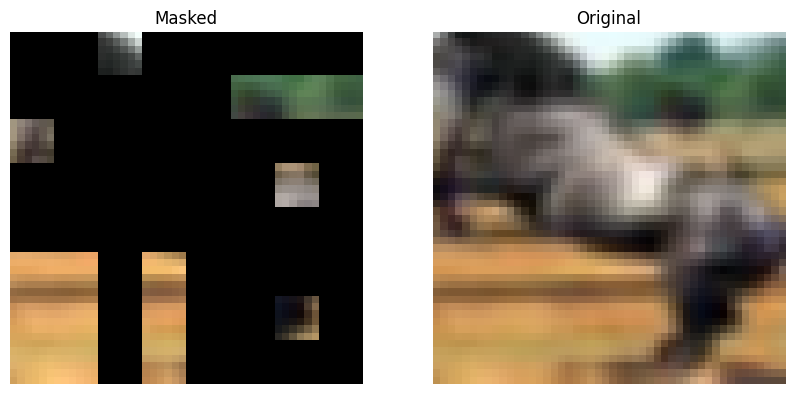

In [7]:
# Show a maksed patch image.
new_patch, random_index = patch_encoder.show_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmeneted_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

# Model init

In [8]:
from missing_modality.MaskedAutoencoder import MaskedAutoencoder

keras.backend.clear_session()

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Training callbacks

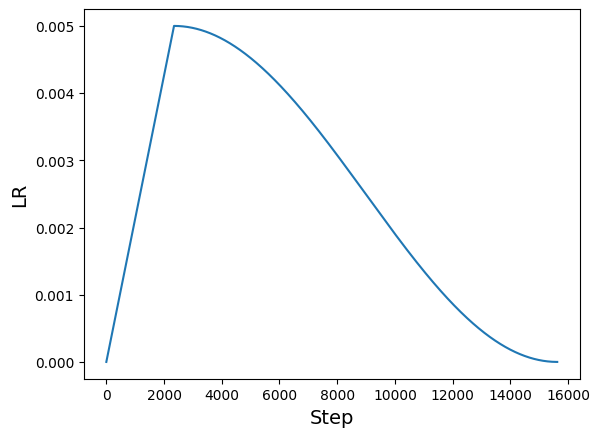

In [9]:
from missing_modality.WarmUpCosine import WarmUpCosine

total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_steps = int(total_steps * 0.15)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [10]:
from missing_modality.TrainMonitor import TrainMonitor

timestamp = datetime.utcnow().strftime("%y%m%d-%H%M%S")

train_callbacks = [
    keras.callbacks.TensorBoard(log_dir=f"mae_logs_{timestamp}"),
    TrainMonitor(test_ds, epoch_interval=5),
]

# Compilation and training

In [11]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

Epoch 1/100
156/157 [============================>.] - ETA: 0s - loss: 0.0507 - mae: 0.1806
Idx chosen: 154


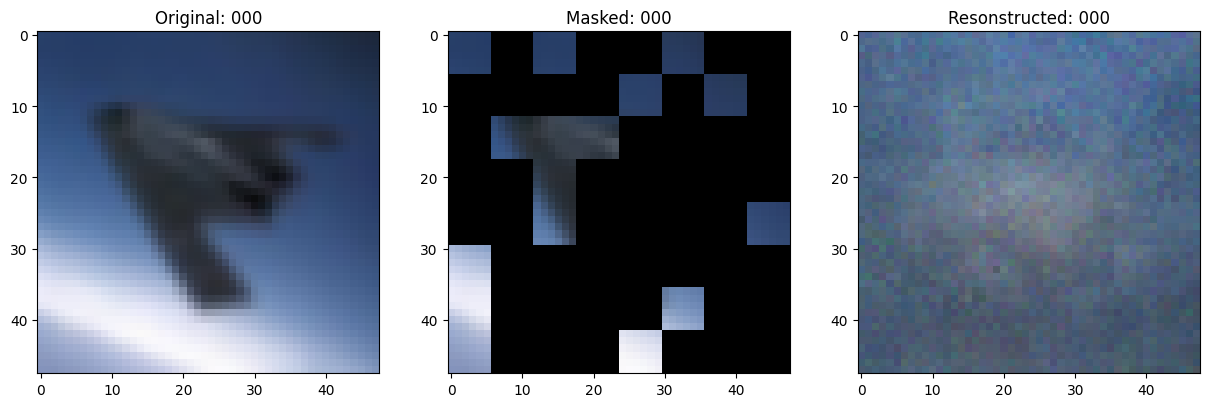

157/157 [==============================] - 16s 66ms/step - loss: 0.0506 - mae: 0.1806 - val_loss: 0.0420 - val_mae: 0.1635
Epoch 2/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0366 - mae: 0.1500 - val_loss: 0.0358 - val_mae: 0.1460
Epoch 3/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0315 - mae: 0.1365 - val_loss: 0.0303 - val_mae: 0.1344
Epoch 4/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0279 - mae: 0.1266 - val_loss: 0.0275 - val_mae: 0.1251
Epoch 5/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0256 - mae: 0.1205 - val_loss: 0.0255 - val_mae: 0.1193
Epoch 6/100
156/157 [============================>.] - ETA: 0s - loss: 0.0236 - mae: 0.1150
Idx chosen: 136


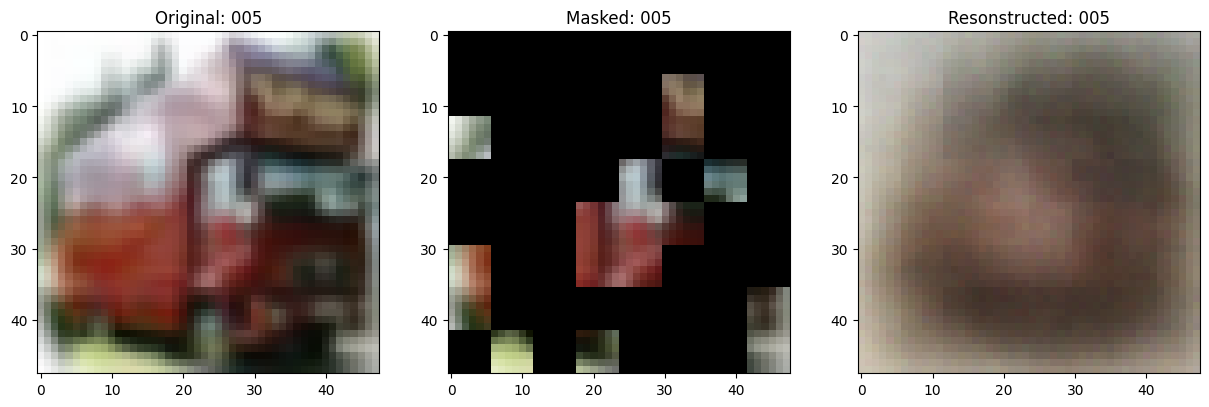

157/157 [==============================] - 10s 61ms/step - loss: 0.0236 - mae: 0.1150 - val_loss: 0.0236 - val_mae: 0.1150
Epoch 7/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0223 - mae: 0.1114 - val_loss: 0.0226 - val_mae: 0.1114
Epoch 8/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0214 - mae: 0.1088 - val_loss: 0.0215 - val_mae: 0.1098
Epoch 9/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0207 - mae: 0.1065 - val_loss: 0.0224 - val_mae: 0.1141
Epoch 10/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0202 - mae: 0.1053 - val_loss: 0.0208 - val_mae: 0.1062
Epoch 11/100
156/157 [============================>.] - ETA: 0s - loss: 0.0200 - mae: 0.1044
Idx chosen: 61


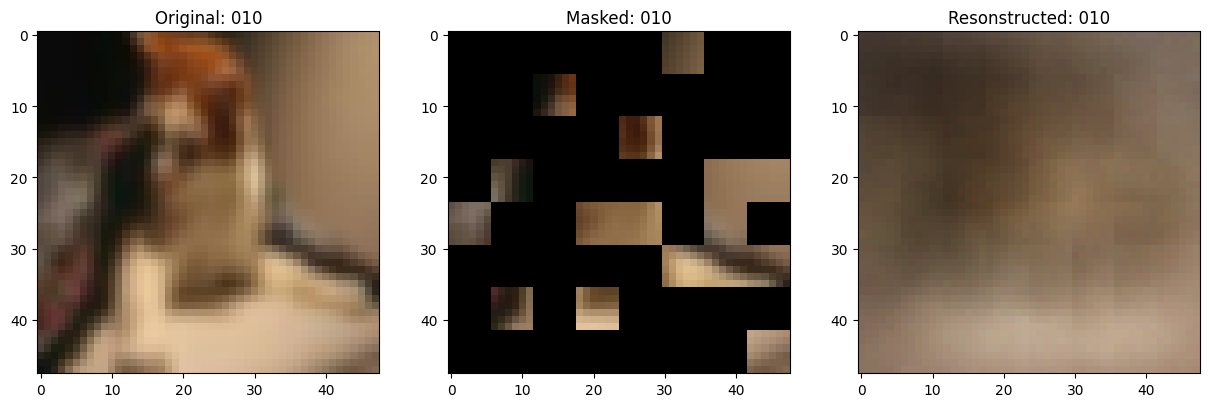

157/157 [==============================] - 10s 61ms/step - loss: 0.0200 - mae: 0.1044 - val_loss: 0.0208 - val_mae: 0.1058
Epoch 12/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0229 - mae: 0.1117 - val_loss: 0.0587 - val_mae: 0.2014
Epoch 13/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0414 - mae: 0.1628 - val_loss: 0.0348 - val_mae: 0.1462
Epoch 14/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0304 - mae: 0.1346 - val_loss: 0.0289 - val_mae: 0.1291
Epoch 15/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0263 - mae: 0.1231 - val_loss: 0.0260 - val_mae: 0.1205
Epoch 16/100
156/157 [============================>.] - ETA: 0s - loss: 0.0237 - mae: 0.1152
Idx chosen: 164


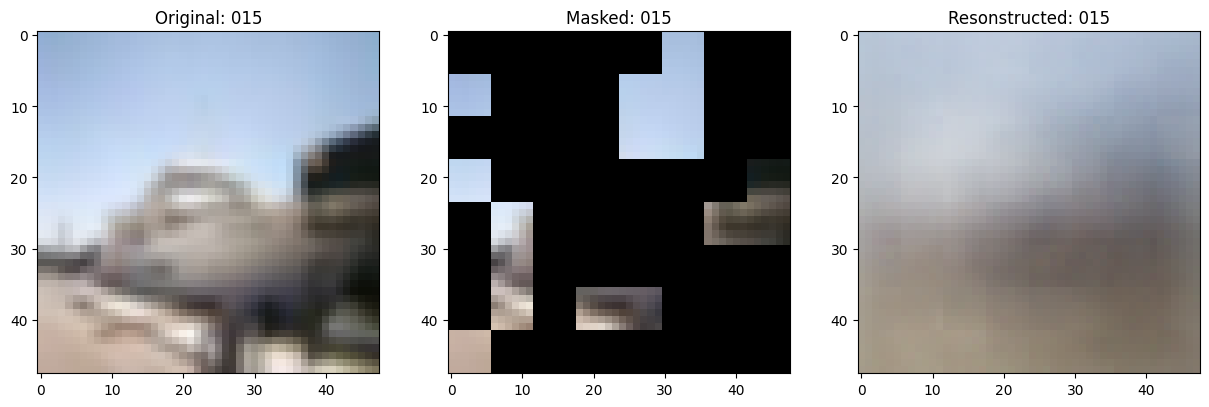

157/157 [==============================] - 10s 61ms/step - loss: 0.0237 - mae: 0.1152 - val_loss: 0.0238 - val_mae: 0.1175
Epoch 17/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0217 - mae: 0.1094 - val_loss: 0.0221 - val_mae: 0.1104
Epoch 18/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0207 - mae: 0.1064 - val_loss: 0.0207 - val_mae: 0.1053
Epoch 19/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0198 - mae: 0.1035 - val_loss: 0.0202 - val_mae: 0.1045
Epoch 20/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0195 - mae: 0.1029 - val_loss: 0.0200 - val_mae: 0.1041
Epoch 21/100
156/157 [============================>.] - ETA: 0s - loss: 0.0190 - mae: 0.1010
Idx chosen: 224


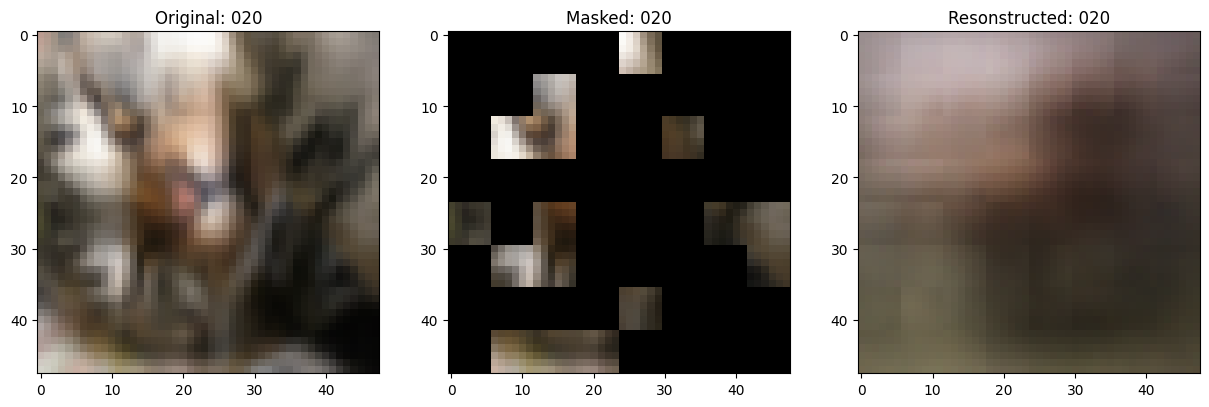

157/157 [==============================] - 10s 63ms/step - loss: 0.0190 - mae: 0.1010 - val_loss: 0.0200 - val_mae: 0.1041
Epoch 22/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0184 - mae: 0.0993 - val_loss: 0.0191 - val_mae: 0.1004
Epoch 23/100
157/157 [==============================] - 10s 61ms/step - loss: 0.0183 - mae: 0.0989 - val_loss: 0.0188 - val_mae: 0.1000
Epoch 24/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0180 - mae: 0.0980 - val_loss: 0.0186 - val_mae: 0.1000
Epoch 25/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0176 - mae: 0.0968 - val_loss: 0.0185 - val_mae: 0.0991
Epoch 26/100
156/157 [============================>.] - ETA: 0s - loss: 0.0174 - mae: 0.0959
Idx chosen: 50


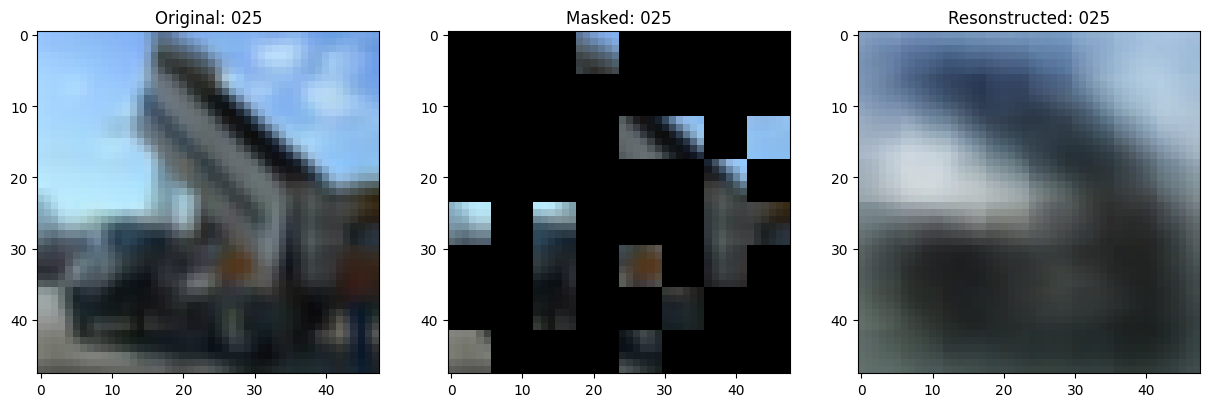

157/157 [==============================] - 10s 62ms/step - loss: 0.0174 - mae: 0.0959 - val_loss: 0.0201 - val_mae: 0.1057
Epoch 27/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0175 - mae: 0.0961 - val_loss: 0.0180 - val_mae: 0.0978
Epoch 28/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0172 - mae: 0.0952 - val_loss: 0.0178 - val_mae: 0.0965
Epoch 29/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0172 - mae: 0.0953 - val_loss: 0.0179 - val_mae: 0.0958
Epoch 30/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0168 - mae: 0.0940 - val_loss: 0.0180 - val_mae: 0.0969
Epoch 31/100
156/157 [============================>.] - ETA: 0s - loss: 0.0168 - mae: 0.0939
Idx chosen: 233


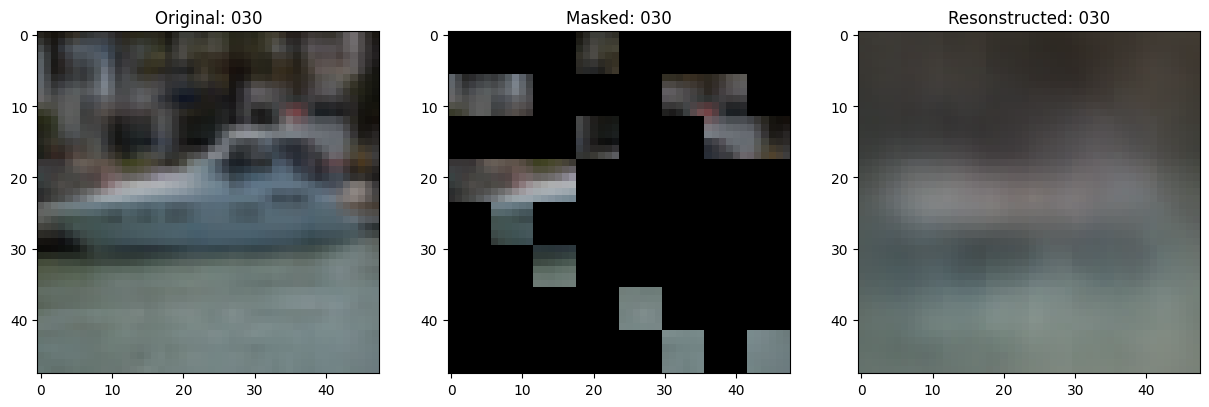

157/157 [==============================] - 10s 62ms/step - loss: 0.0168 - mae: 0.0939 - val_loss: 0.0175 - val_mae: 0.0961
Epoch 32/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0166 - mae: 0.0931 - val_loss: 0.0172 - val_mae: 0.0953
Epoch 33/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0164 - mae: 0.0926 - val_loss: 0.0171 - val_mae: 0.0945
Epoch 34/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0163 - mae: 0.0922 - val_loss: 0.0170 - val_mae: 0.0939
Epoch 35/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0163 - mae: 0.0922 - val_loss: 0.0173 - val_mae: 0.0948
Epoch 36/100
156/157 [============================>.] - ETA: 0s - loss: 0.0162 - mae: 0.0917
Idx chosen: 171


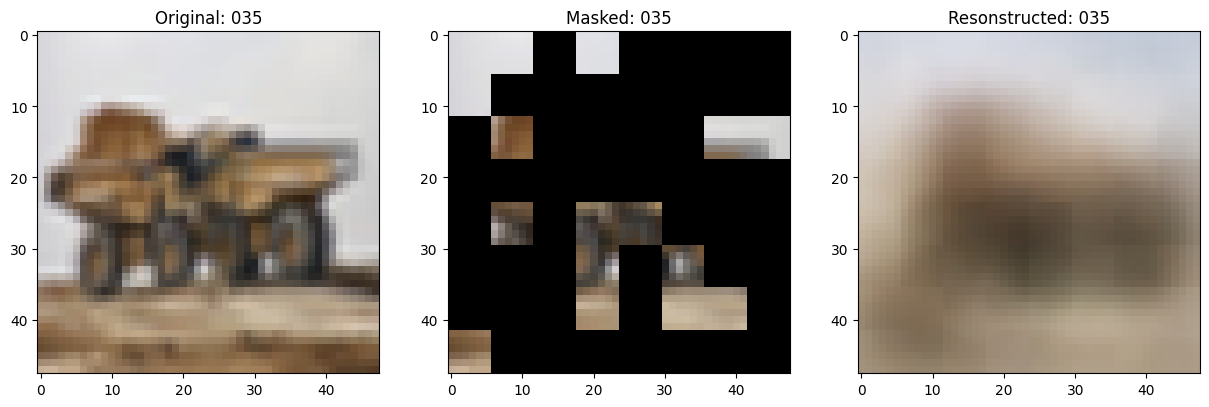

157/157 [==============================] - 10s 62ms/step - loss: 0.0162 - mae: 0.0917 - val_loss: 0.0170 - val_mae: 0.0943
Epoch 37/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0160 - mae: 0.0913 - val_loss: 0.0175 - val_mae: 0.0961
Epoch 38/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0160 - mae: 0.0912 - val_loss: 0.0170 - val_mae: 0.0943
Epoch 39/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0159 - mae: 0.0908 - val_loss: 0.0169 - val_mae: 0.0940
Epoch 40/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0157 - mae: 0.0901 - val_loss: 0.0166 - val_mae: 0.0933
Epoch 41/100
157/157 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.0903
Idx chosen: 151


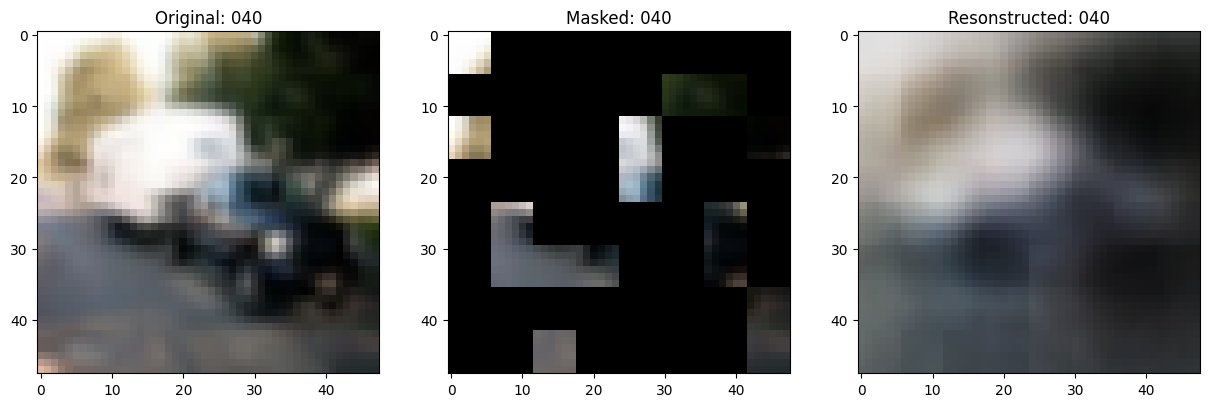

157/157 [==============================] - 10s 62ms/step - loss: 0.0157 - mae: 0.0903 - val_loss: 0.0170 - val_mae: 0.0935
Epoch 42/100
157/157 [==============================] - 10s 61ms/step - loss: 0.0156 - mae: 0.0898 - val_loss: 0.0170 - val_mae: 0.0952
Epoch 43/100
157/157 [==============================] - 10s 61ms/step - loss: 0.0155 - mae: 0.0896 - val_loss: 0.0165 - val_mae: 0.0915
Epoch 44/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0153 - mae: 0.0887 - val_loss: 0.0165 - val_mae: 0.0930
Epoch 45/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0154 - mae: 0.0889 - val_loss: 0.0162 - val_mae: 0.0911
Epoch 46/100
156/157 [============================>.] - ETA: 0s - loss: 0.0153 - mae: 0.0886
Idx chosen: 206


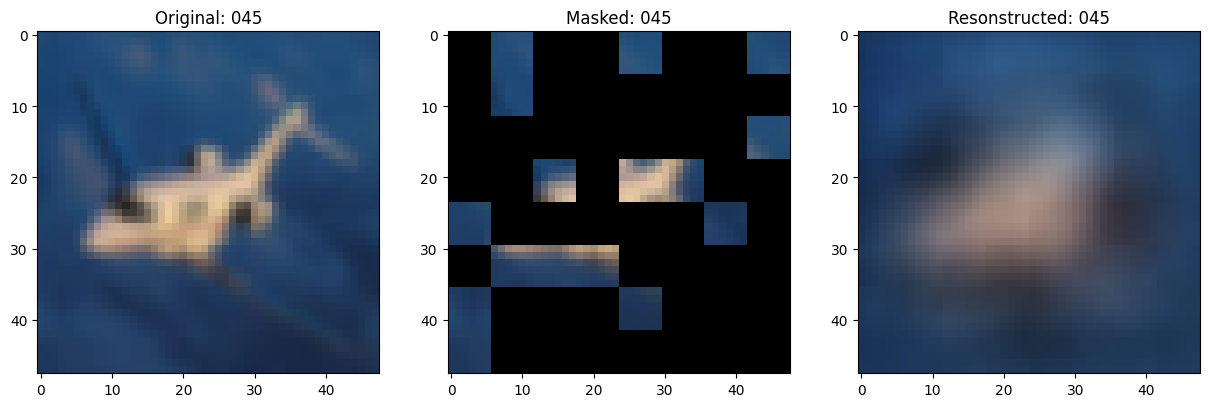

157/157 [==============================] - 10s 62ms/step - loss: 0.0153 - mae: 0.0886 - val_loss: 0.0162 - val_mae: 0.0911
Epoch 47/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0152 - mae: 0.0882 - val_loss: 0.0161 - val_mae: 0.0902
Epoch 48/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0150 - mae: 0.0877 - val_loss: 0.0161 - val_mae: 0.0904
Epoch 49/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0150 - mae: 0.0877 - val_loss: 0.0161 - val_mae: 0.0905
Epoch 50/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0150 - mae: 0.0874 - val_loss: 0.0160 - val_mae: 0.0910
Epoch 51/100
156/157 [============================>.] - ETA: 0s - loss: 0.0149 - mae: 0.0872
Idx chosen: 58


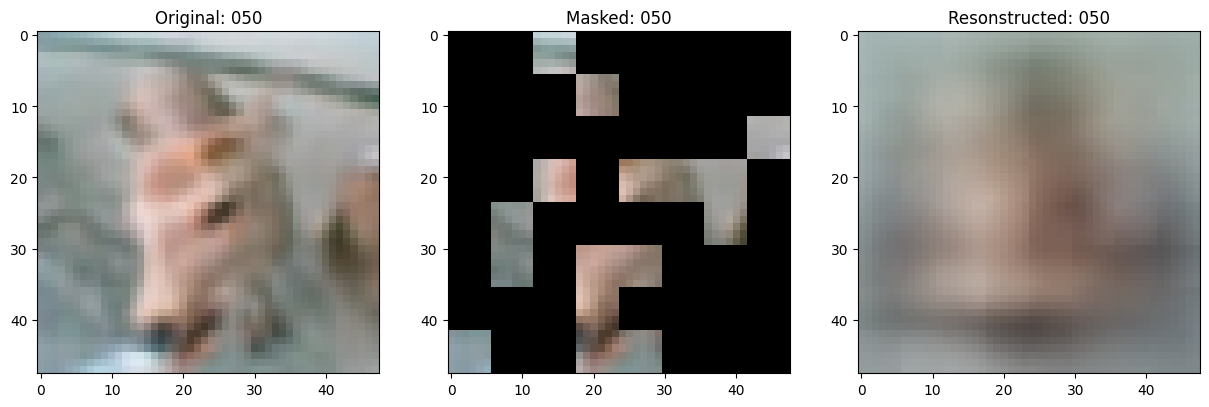

157/157 [==============================] - 10s 63ms/step - loss: 0.0149 - mae: 0.0873 - val_loss: 0.0167 - val_mae: 0.0937
Epoch 52/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0149 - mae: 0.0870 - val_loss: 0.0162 - val_mae: 0.0915
Epoch 53/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0148 - mae: 0.0867 - val_loss: 0.0158 - val_mae: 0.0893
Epoch 54/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0147 - mae: 0.0865 - val_loss: 0.0158 - val_mae: 0.0889
Epoch 55/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0146 - mae: 0.0862 - val_loss: 0.0161 - val_mae: 0.0917
Epoch 56/100
156/157 [============================>.] - ETA: 0s - loss: 0.0145 - mae: 0.0858
Idx chosen: 117


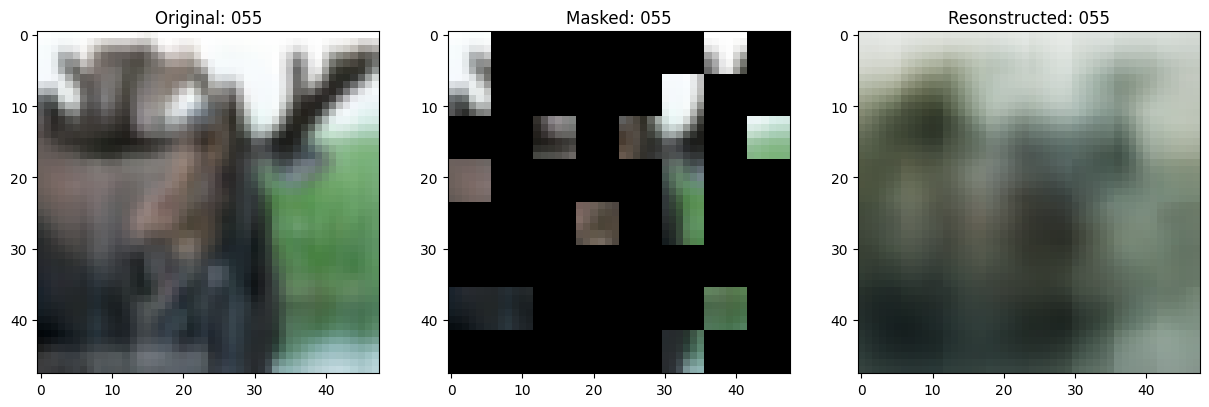

157/157 [==============================] - 10s 63ms/step - loss: 0.0145 - mae: 0.0858 - val_loss: 0.0158 - val_mae: 0.0888
Epoch 57/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0145 - mae: 0.0857 - val_loss: 0.0156 - val_mae: 0.0882
Epoch 58/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0145 - mae: 0.0855 - val_loss: 0.0156 - val_mae: 0.0891
Epoch 59/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0144 - mae: 0.0853 - val_loss: 0.0155 - val_mae: 0.0884
Epoch 60/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0143 - mae: 0.0849 - val_loss: 0.0153 - val_mae: 0.0875
Epoch 61/100
156/157 [============================>.] - ETA: 0s - loss: 0.0142 - mae: 0.0847
Idx chosen: 159


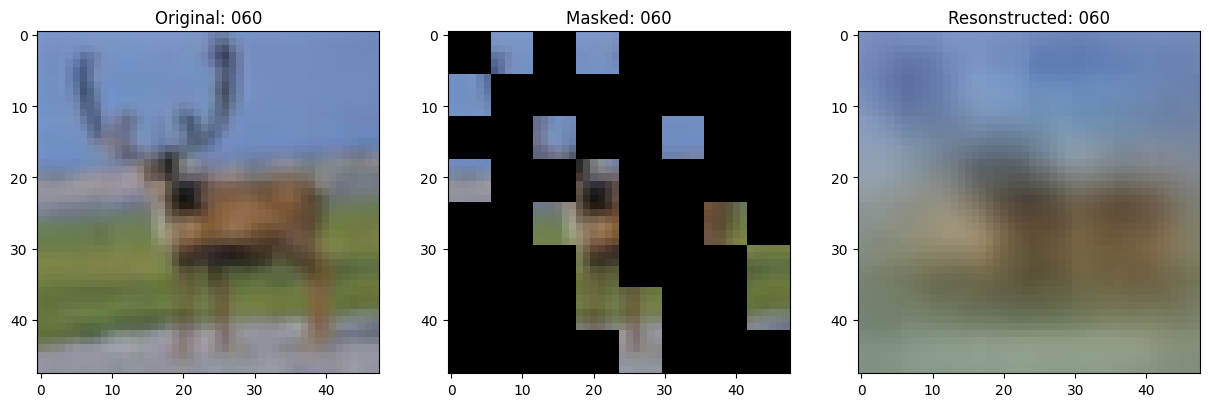

157/157 [==============================] - 10s 63ms/step - loss: 0.0142 - mae: 0.0847 - val_loss: 0.0156 - val_mae: 0.0882
Epoch 62/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0142 - mae: 0.0846 - val_loss: 0.0155 - val_mae: 0.0873
Epoch 63/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0142 - mae: 0.0845 - val_loss: 0.0154 - val_mae: 0.0876
Epoch 64/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0141 - mae: 0.0841 - val_loss: 0.0155 - val_mae: 0.0880
Epoch 65/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0140 - mae: 0.0838 - val_loss: 0.0152 - val_mae: 0.0868
Epoch 66/100
156/157 [============================>.] - ETA: 0s - loss: 0.0140 - mae: 0.0836
Idx chosen: 95


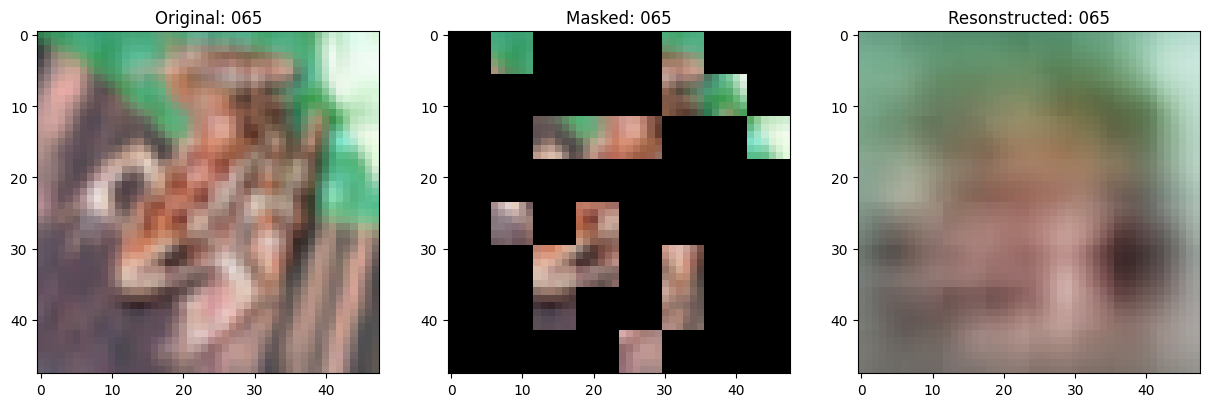

157/157 [==============================] - 10s 62ms/step - loss: 0.0140 - mae: 0.0836 - val_loss: 0.0153 - val_mae: 0.0874
Epoch 67/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0139 - mae: 0.0834 - val_loss: 0.0152 - val_mae: 0.0867
Epoch 68/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0139 - mae: 0.0832 - val_loss: 0.0151 - val_mae: 0.0870
Epoch 69/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0138 - mae: 0.0829 - val_loss: 0.0150 - val_mae: 0.0866
Epoch 70/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0137 - mae: 0.0827 - val_loss: 0.0155 - val_mae: 0.0886
Epoch 71/100
157/157 [==============================] - ETA: 0s - loss: 0.0137 - mae: 0.0825
Idx chosen: 215


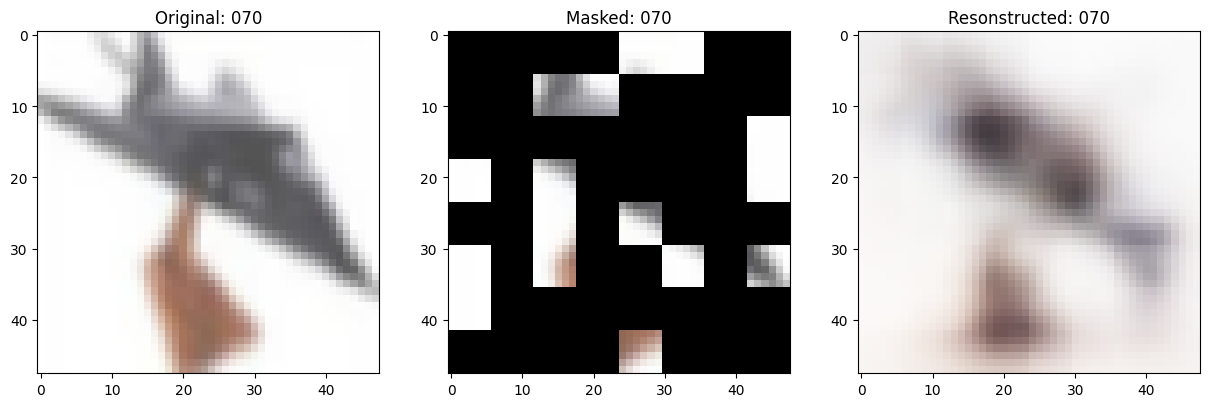

157/157 [==============================] - 10s 62ms/step - loss: 0.0137 - mae: 0.0825 - val_loss: 0.0151 - val_mae: 0.0869
Epoch 72/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0137 - mae: 0.0824 - val_loss: 0.0149 - val_mae: 0.0858
Epoch 73/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0136 - mae: 0.0821 - val_loss: 0.0149 - val_mae: 0.0859
Epoch 74/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0135 - mae: 0.0818 - val_loss: 0.0152 - val_mae: 0.0874
Epoch 75/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0135 - mae: 0.0817 - val_loss: 0.0150 - val_mae: 0.0862
Epoch 76/100
156/157 [============================>.] - ETA: 0s - loss: 0.0135 - mae: 0.0815
Idx chosen: 232


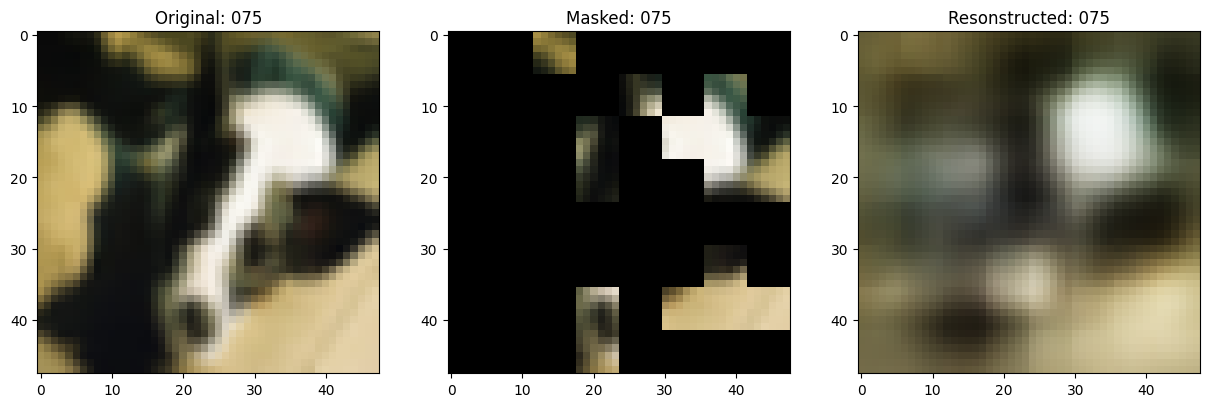

157/157 [==============================] - 10s 62ms/step - loss: 0.0135 - mae: 0.0815 - val_loss: 0.0149 - val_mae: 0.0857
Epoch 77/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0134 - mae: 0.0812 - val_loss: 0.0148 - val_mae: 0.0856
Epoch 78/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0134 - mae: 0.0811 - val_loss: 0.0147 - val_mae: 0.0849
Epoch 79/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0133 - mae: 0.0808 - val_loss: 0.0146 - val_mae: 0.0847
Epoch 80/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0133 - mae: 0.0809 - val_loss: 0.0147 - val_mae: 0.0849
Epoch 81/100
156/157 [============================>.] - ETA: 0s - loss: 0.0132 - mae: 0.0805
Idx chosen: 179


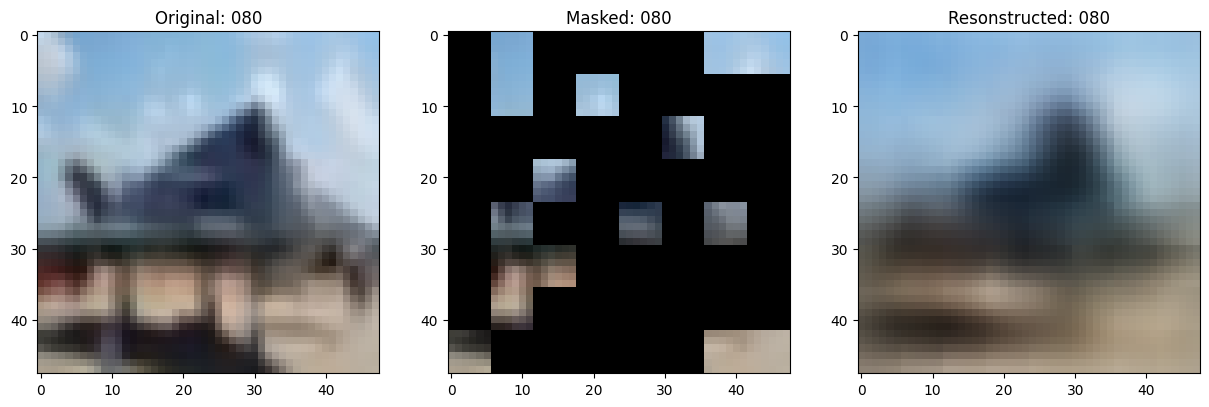

157/157 [==============================] - 10s 62ms/step - loss: 0.0132 - mae: 0.0805 - val_loss: 0.0146 - val_mae: 0.0845
Epoch 82/100
157/157 [==============================] - 10s 62ms/step - loss: 0.0132 - mae: 0.0804 - val_loss: 0.0145 - val_mae: 0.0842
Epoch 83/100
157/157 [==============================] - 9s 60ms/step - loss: 0.0132 - mae: 0.0801 - val_loss: 0.0145 - val_mae: 0.0842
Epoch 84/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0132 - mae: 0.0801 - val_loss: 0.0146 - val_mae: 0.0844
Epoch 85/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0131 - mae: 0.0797 - val_loss: 0.0146 - val_mae: 0.0846
Epoch 86/100
156/157 [============================>.] - ETA: 0s - loss: 0.0131 - mae: 0.0798
Idx chosen: 112


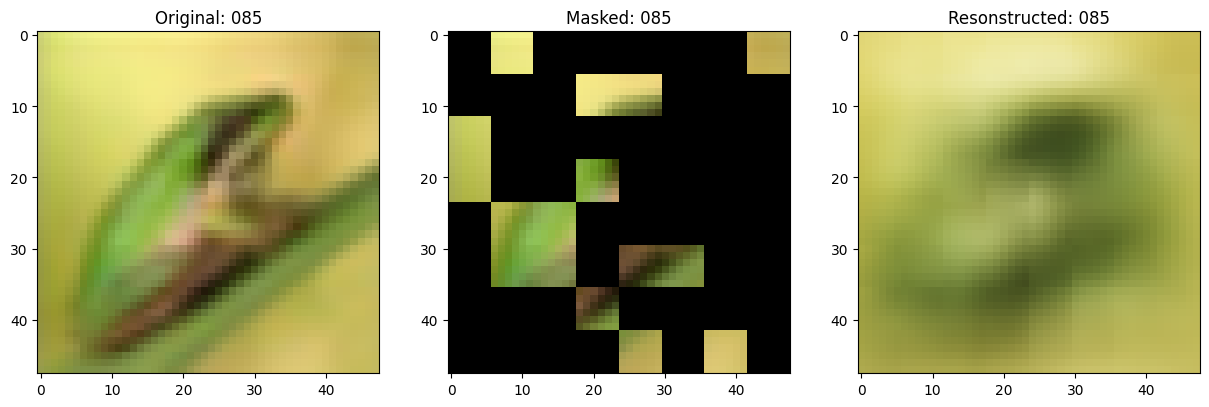

157/157 [==============================] - 10s 62ms/step - loss: 0.0131 - mae: 0.0798 - val_loss: 0.0147 - val_mae: 0.0848
Epoch 87/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0130 - mae: 0.0795 - val_loss: 0.0144 - val_mae: 0.0838
Epoch 88/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0130 - mae: 0.0794 - val_loss: 0.0144 - val_mae: 0.0836
Epoch 89/100
157/157 [==============================] - 9s 58ms/step - loss: 0.0129 - mae: 0.0792 - val_loss: 0.0144 - val_mae: 0.0835
Epoch 90/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0129 - mae: 0.0792 - val_loss: 0.0143 - val_mae: 0.0833
Epoch 91/100
156/157 [============================>.] - ETA: 0s - loss: 0.0129 - mae: 0.0791
Idx chosen: 61


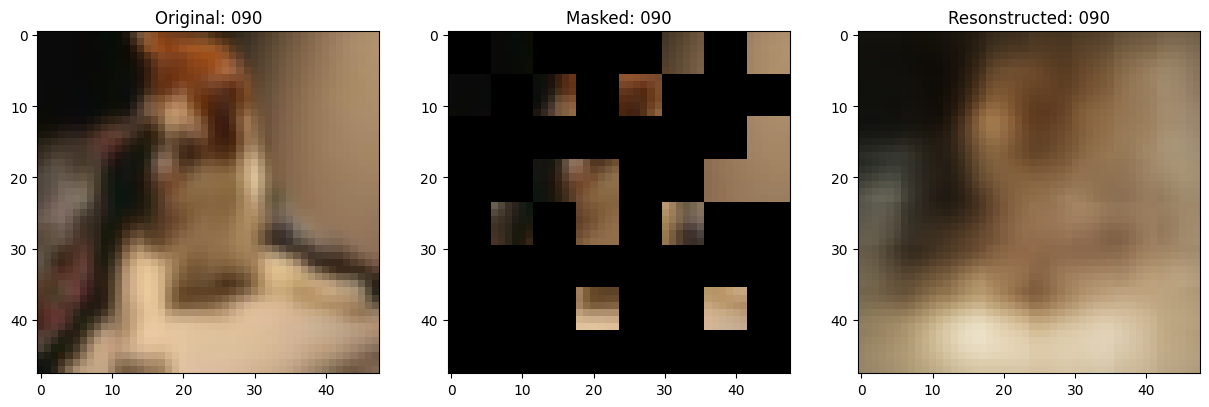

157/157 [==============================] - 10s 62ms/step - loss: 0.0129 - mae: 0.0791 - val_loss: 0.0144 - val_mae: 0.0835
Epoch 92/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0129 - mae: 0.0789 - val_loss: 0.0143 - val_mae: 0.0837
Epoch 93/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0129 - mae: 0.0790 - val_loss: 0.0143 - val_mae: 0.0834
Epoch 94/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0129 - mae: 0.0790 - val_loss: 0.0143 - val_mae: 0.0833
Epoch 95/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0129 - mae: 0.0789 - val_loss: 0.0143 - val_mae: 0.0834
Epoch 96/100
156/157 [============================>.] - ETA: 0s - loss: 0.0129 - mae: 0.0790
Idx chosen: 240


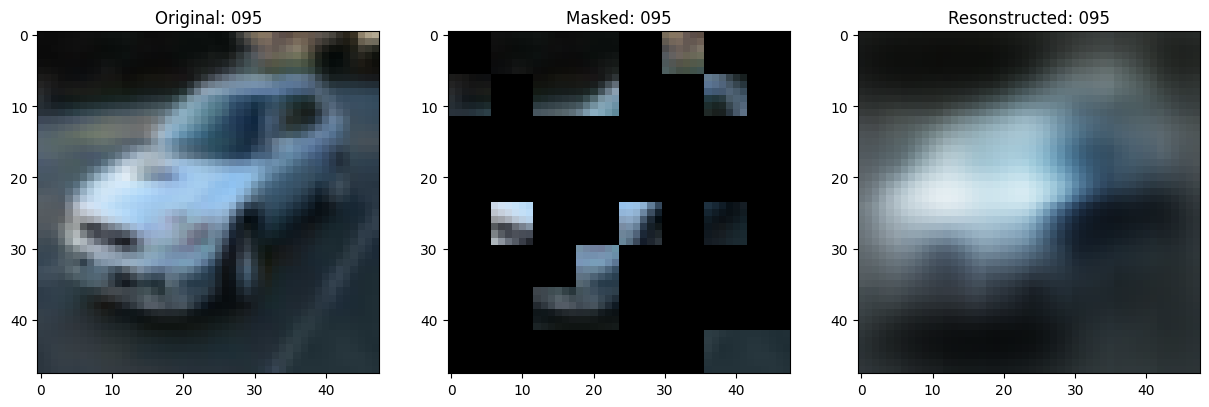

157/157 [==============================] - 10s 62ms/step - loss: 0.0129 - mae: 0.0790 - val_loss: 0.0143 - val_mae: 0.0834
Epoch 97/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0130 - mae: 0.0793 - val_loss: 0.0144 - val_mae: 0.0837
Epoch 98/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0130 - mae: 0.0795 - val_loss: 0.0144 - val_mae: 0.0839
Epoch 99/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0131 - mae: 0.0799 - val_loss: 0.0145 - val_mae: 0.0844
Epoch 100/100
157/157 [==============================] - 9s 59ms/step - loss: 0.0133 - mae: 0.0810 - val_loss: 0.0146 - val_mae: 0.0857


In [12]:
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

In [13]:
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

40/40 [==============================] - 1s 20ms/step - loss: 0.0147 - mae: 0.0857
Loss: 0.01
MAE: 0.09


# Downstrean Task

In [14]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing)
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches (Patches)           (None, 64, 108)           0         
                                                                 
 patch_encoder (PatchEncoder  (None, 64, 128)          22252     
 )                                                               
                                                                 
 mae_encoder (Functional)    (None, None, 128)         990976    
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [15]:
train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [ ]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
157/157 [==============================] - 12s 59ms/step - loss: 2.2350 - accuracy: 0.1848 - val_loss: 2.0053 - val_accuracy: 0.3150
Epoch 2/50
157/157 [==============================] - 9s 55ms/step - loss: 1.8932 - accuracy: 0.3540 - val_loss: 1.7683 - val_accuracy: 0.3868
Epoch 3/50
157/157 [==============================] - 9s 55ms/step - loss: 1.7488 - accuracy: 0.3931 - val_loss: 1.6776 - val_accuracy: 0.4130
Epoch 4/50
157/157 [==============================] - 9s 55ms/step - loss: 1.6834 - accuracy: 0.4122 - val_loss: 1.6293 - val_accuracy: 0.4265
Epoch 5/50
157/157 [==============================] - 9s 55ms/step - loss: 1.6479 - accuracy: 0.4204 - val_loss: 1.5969 - val_accuracy: 0.4362
Epoch 6/50
157/157 [==============================] - 9s 55ms/step - loss: 1.6201 - accuracy: 0.4267 - val_loss: 1.5752 - val_accuracy: 0.4412
Epoch 7/50
157/157 [==============================] - 9s 55ms/step - loss: 1.6047 - accuracy: 0.4291 - val_loss: 1.5590 - val_accuracy: 0.447

In [ ]:
downstream_model.save(f"linear_probe_{timestamp}", include_optimizer=False)